In [1]:
import sys                       
sys.path.append('../scripts/')
from robot import *
from scipy.stats import uniform, norm ###spike_noise_header###

In [2]:
class RandomRobot(Robot):   ###spike_noise###
    
    def spike_noise(self,prob=0.0,angle_stderr=math.pi/60): #確率0、雑音の標準偏差3[deg]
        t_noise = 0.0
        
        if uniform.rvs() < prob:   #0~1から1つ値を選んで閾値と比較
            t_noise = norm.rvs(scale=angle_stderr) #ガウス分布から値をドロー

        return np.array([0.0, 0.0, t_noise]) #x,yと共に返す
        
    def func_state_transition(self, nu, omega, time, pose):
        return super().func_state_transition(nu, omega, time, pose) \
                       + self.spike_noise(prob=0.1)

<IPython.core.display.Javascript object>


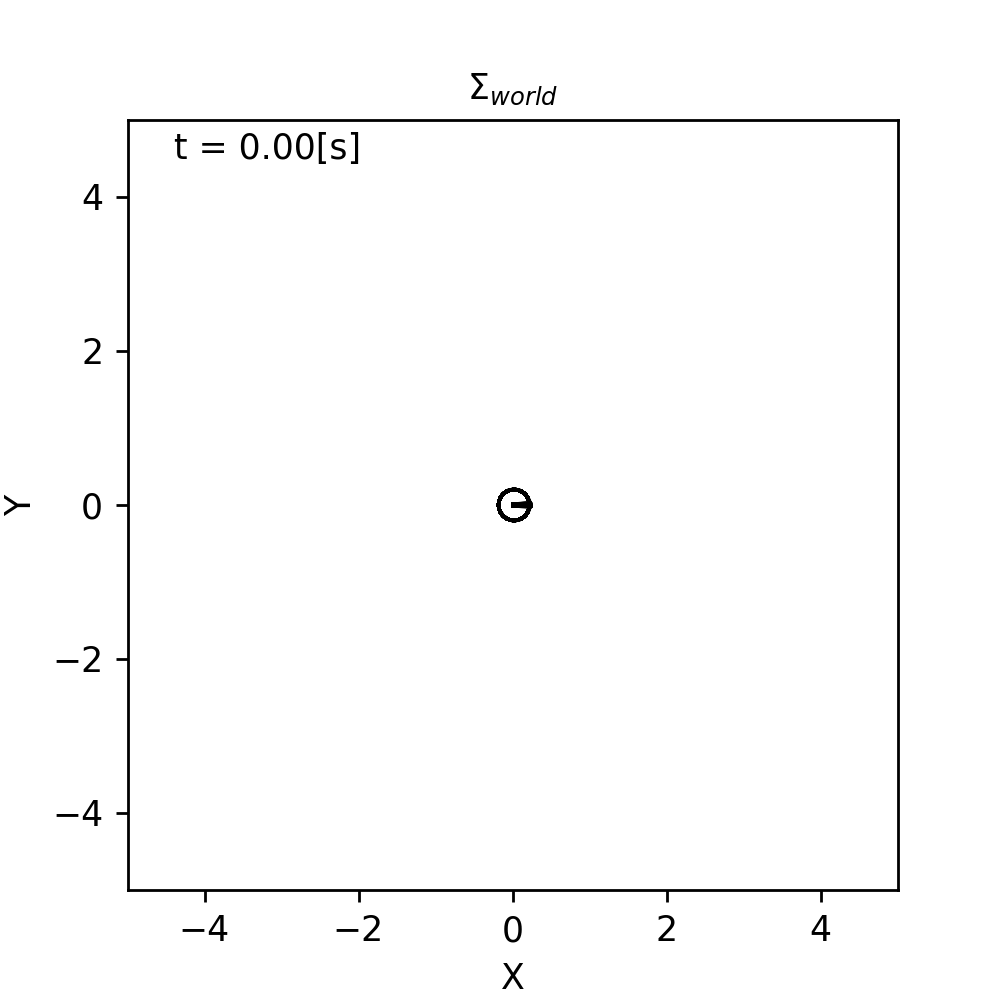

In [3]:
world = World(0.1, 0.1)

for i in range(100):
    circling = Agent(0.2, 10.0/180*math.pi)
    r = RandomRobot( np.array([0, 0, 0]).T, sensor=None, agent=circling ) 
    world.append(r)

world.draw()